In [32]:
# Data Handling
import numpy as np
import pandas as pd
import h5py
from torch.utils.data import DataLoader, TensorDataset

# Machine Learning & Deep Learning
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd

# Neuroimaging
import nibabel as nib  # For loading NIfTI files
from nilearn.connectome import ConnectivityMeasure  # For connectivity matrices

# Data Preprocessing & Visualization
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns

# LOADING THE DATA

In [2]:
file_path = "Data_ML/SC_FC_dataset_filtered_68x68.h5"

In [3]:
# Load data for CTRL and SCHZ
with h5py.File(file_path, "r") as f:
    ctrl_data = f["SC_ADC"]["ctrl"][:]  # Load control group data
    schz_data = f["SC_ADC"]["schz"][:]  # Load schizophrenia group data

ctrl_data = (ctrl_data - np.min(ctrl_data)) / (np.max(ctrl_data) - np.min(ctrl_data))  # Normalize to [0,1]
ctrl_data = 2 * ctrl_data - 1  # Normalize to [-1,1]
ctrl_tensor = torch.tensor(ctrl_data, dtype=torch.float32).unsqueeze(1)  # Add channel dimension

schz_data = (schz_data - np.min(schz_data)) / (np.max(schz_data) - np.min(schz_data))  
schz_data = 2 * schz_data - 1 
schz_tensor = torch.tensor(schz_data, dtype=torch.float32).unsqueeze(1) 


train_data = ctrl_tensor
batch_size = 32

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Method 1: Using GANs (Generative Adversarial Networks)

# A. Conventional GAN

*A priori*, this should not be the optimal method as conventional GANs are usually not the best approaches for complex datasets, such as connectomes.

**i. Generator** creates fake data

In [11]:
class Generator_GAN(nn.Module):
    def __init__(self, latent_dim):
        super(Generator_GAN, self).__init__()
        self.model =  nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 68 * 68),
            nn.Tanh()  # Output in range [-1; 1]
        )
    def forward(self, z):
        return self.model(z).view(-1, 1, 68, 68)

**ii. Discriminator** tries to distinguish real from fake

In [12]:
class Discriminator_GAN(nn.Module):
    def __init__(self):
        super(Discriminator_GAN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(68 * 68, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1),  # Represents the network’s confidence about input image being real or generated
            nn.Sigmoid()  # Output probability of being real
        )

    def forward(self, x):
        return self.model(x.view(-1, 68 * 68))

**Why we use Leaky ReLUs in the Discriminator and normal ones in the Generator** : 

ReLUs can suffer from the *dying ReLU* problem where some neurons get stuck and stop learning because they always output zero. However, in the context of the Generator, ReLU allows efficient learning for the Generator. Additionally, batch normalization normalizes the activations within each batch, which helps control the scale of the activations and reduces the risk of vanishing or exploding gradients. Lastly, the Generator usually has a higher learning rate than the Discriminator, which also accounts for the fact that it is not as problematic as it could be with the latter.

A LeakyReLU mitigates the *dying ReLU* issue by allowing a small, non-zero gradient for negative inputs. This ensures that even if a neuron’s output is negative, it still has some gradient flow during backpropagation and does not get "stuck" during training. In the Discriminator, we want to make sure that the model's weights are updated appropriately, even if the output of a neuron is negative. LeakyReLU allows this, because instead of zeroing out negative activations like normal ReLU does, it allows a small negative slope. This helps keep the gradient flow alive, preventing parts of the Discriminator from becoming inactive or "dead."

**iii. Training loop**

In [126]:
# Hyperparameters
latent_dim = 100  # Dimensionality of the input noise vector
lr_G = 0.0004
lr_D = 0.0002
epochs = 5000

# Initialize models
generator = Generator_GAN(latent_dim)
discriminator = Discriminator_GAN()

# Loss & Optimizers
criterion = nn.BCELoss()  # Task is binary classification — distinguishing real from fake data
optimizer_G = optim.Adam(generator.parameters(), lr=lr_G, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr_D, betas=(0.5, 0.999))

# Training Loop
for epoch in range(epochs):
    for real_data in train_loader:
        real_data = real_data.view(-1, 68 * 68)  # Flatten (cf. Discriminator input)
        batch_size = real_data.size(0)

        # Generate fake data
        z = torch.randn(batch_size, latent_dim)  #  Sample random noise (latent vector, of dim = latent_dim)
        fake_data = generator(z)

        # Train Discriminator : learns to distinguish real from fake samples
        optimizer_D.zero_grad()
        real_loss = criterion(discriminator(real_data), torch.ones(batch_size, 1))  # Real -> 1
        fake_loss = criterion(discriminator(fake_data.detach()), torch.zeros(batch_size, 1))  # Fake -> 0
        loss_D = real_loss + fake_loss
        loss_D.backward()
        optimizer_D.step()

        # Train Generator : tries to fool the Discriminator by generating realistic data 
        
        optimizer_G.zero_grad()
        loss_G = criterion(discriminator(fake_data), torch.ones(batch_size, 1))  # Fool Discriminator
        loss_G.backward()
        optimizer_G.step()    

    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Loss_D={loss_D.item()}, Loss_G={loss_G.item()}")

Epoch 0: Loss_D=1.3239789009094238, Loss_G=0.6940433979034424
Epoch 500: Loss_D=1.5226798057556152, Loss_G=0.6303067803382874
Epoch 1000: Loss_D=1.5351269245147705, Loss_G=0.6104888916015625
Epoch 1500: Loss_D=1.2119834423065186, Loss_G=0.8381507992744446
Epoch 2000: Loss_D=1.3180224895477295, Loss_G=0.6941385865211487
Epoch 2500: Loss_D=1.4032493829727173, Loss_G=0.7625053524971008
Epoch 3000: Loss_D=1.4526314735412598, Loss_G=0.659332811832428
Epoch 3500: Loss_D=1.4264601469039917, Loss_G=0.6788215041160583
Epoch 4000: Loss_D=1.4311171770095825, Loss_G=0.7471550703048706
Epoch 4500: Loss_D=1.4228932857513428, Loss_G=0.66986083984375


**Why do we choose a low learning rate ?** Because GANs are notorious for being unstable to train, as the Generator and Discriminator are trying to outsmart each other in a zero-sum game. Therefore, a lower learning rate allows for more gradual and controlled updates, preventing one network from overshooting the other during training, which helps to balance the learning process between the Generator and Discriminator.

**iv. Generating and plotting new samples**

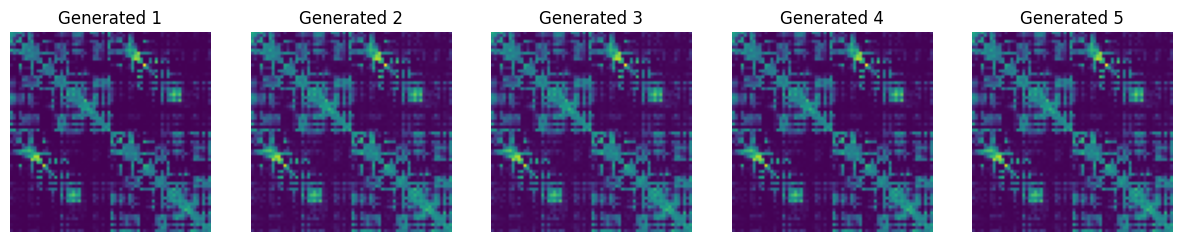

In [127]:
generator.eval()

# Generate new fake samples
with torch.no_grad():
    z_test = torch.randn(5, latent_dim)  
    new_fake = generator(z_test).cpu().numpy()
new_fake = new_fake[:, 0]

fig, axes = plt.subplots(1, 5, figsize=(15, 6))

for i in range(5):
    axes[i].imshow(new_fake[i], cmap="viridis")
    axes[i].set_title(f"Generated {i+1}")
    axes[i].axis("off")

plt.show()

The generated images seem to have the same details (for instance, by comparing the locations of yellow dots), which may indicate mode collapse and / or overfitting, something not surprising when using GANs.

Indeed, GANs are known not to be best suited for high-complexity data. WGANs being supposedly more better suited to such data, let's Generate connectomes with WGANs.

# B. Gradient penalty Wasserstein GAN (GP-WGAN)

Traditional GANs use the Jensen-Shannon (JS) divergence or Kullback-Leibler (KL) divergence as distance metrics between real and generated data distributions, which can lead to mode collapse and training instability.

WGAN introduces the Wasserstein distance (Earth Mover's Distance) as a better measure of distance between probability distributions, that stabilizes training. They are better suited to high-complexity connectomes.

Instead of a Discriminator, a WGAN uses a Critic function, which must satisfy the 1-Lipschitz constraint to ensure the Wasserstein distance is properly computed. Originally, WGAN enforced this using **weight clipping**, but this led to poor optimisation and vanishing gradients. Instead of clipping weights, WGAN-GP **penalizes the gradient** norm of the critic function by adding a term to the loss function : $\lambda \cdot (\|\nabla_{\hat{x}} D(\hat{x})\|_2 - 1)^2$.


The Wasserstein loss used to train the Critic is : $\mathbb{E}[D(G(z))] - \mathbb{E}[D(x)]$

Hence, the total loss is : $\mathbb{E}[D(G(z))] - \mathbb{E}[D(x)] + \lambda \cdot (\|\nabla_{\hat{x}} D(\hat{x})\|_2 - 1)^2$, while the Generator loss is : $-\mathbb{E}[D(G(z))]$

**i. Generator** which maps random noise z to a generated image, as in a conventional GAN -> *we implement WGAN with GAN generator*

**ii. Critic (instead of discriminator)** that outputs a scalar score (instead of class probabilities) indicating how real the input is

In [138]:
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(68 * 68, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 1)  # No Sigmoid since the output is a real-valued score.
        )

    def forward(self, x):
        return self.model(x.view(-1, 68 * 68))


**iii. Gradient penalty**

Computing **gradient penalty** to avoid weight clipping (which is used for usual WGAN) : weight clipping forces parameters into a small range, such that the Critic becomes less expressive and underfits. This is especially problematic when working with high-dimensional data. In contrast, WGAN-GP enforces the Lipschitz constraint by penalizing gradients that deviate from 1. This removes the problems of weight clipping and allows a more more stable training process, allowing WGAN-GP to generate higher-quality samples and to converge faster. By choosing WGAN-GP, Adam can be used as an optimizer.

In [139]:
def compute_gradient_penalty(critic, real_samples, fake_samples, lambda_gp=10):
    batch_size = min(real_samples.size(0), fake_samples.size(0)) # Ensure samples are the same size

    real_samples = real_samples[:batch_size]
    fake_samples = fake_samples[:batch_size]

    # Sample alpha from uniform distribution
    alpha = torch.rand(batch_size, 1, 1).to(real_samples.device)  # Match batch size
    # Interpolation between real data and fake data
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)

    critic_interpolates = critic(interpolates)

    gradients = autograd.grad(
        outputs=critic_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(critic_interpolates),
        create_graph=True, retain_graph=True
    )[0]

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * lambda_gp
    return gradient_penalty

**lambda_gp** is a regularization hyperparameter that scales the gradient penalty in the WGAN-GP loss function. It ensures the 1-Lipschitz continuity condition by penalizing large gradients.

**Training WGAN-GP**

In [142]:
n_critic = 8  # Train the Critic 8 times per Generator step
lambda_gp = 10
lr_C = 0.00005
num_epochs = 500

generator = Generator_GAN(latent_dim).cpu()  # We take the same Generator for WGAN as for the conventional GAN
critic = Critic().cpu()

optimizer_G = optim.Adam(generator.parameters(), lr=lr_G, betas=(0.5, 0.9))
optimizer_C = optim.Adam(critic.parameters(), lr=lr_C, betas=(0.5, 0.9))

In [143]:
for epoch in range(num_epochs):
    for i, data in enumerate(train_loader):
        real_samples = data[0]
        real_samples = real_samples.cpu()

        for _ in range(n_critic):
            optimizer_C.zero_grad()

            # Generate fake samples
            z = torch.randn(batch_size, latent_dim).cpu()
            fake_samples = generator(z)

            
            loss_critic = critic(fake_samples).mean() - critic(real_samples).mean()
            gradient_penalty = compute_gradient_penalty(critic, real_samples, fake_samples, lambda_gp)

            total_loss_C = loss_critic + gradient_penalty
            total_loss_C.backward()
            optimizer_C.step()

        # Train Generator once per loop
        if i % n_critic == 0:
            optimizer_G.zero_grad()

            z = torch.randn(batch_size, latent_dim).cpu()
            fake_samples = generator(z)

            loss_generator = -critic(fake_samples).mean()
            loss_generator.backward()
            optimizer_G.step()

    if epoch % 25 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] | Critic Loss: {total_loss_C.item():.4f} | Generator Loss: {loss_generator.item():.4f}")

Epoch [1/500] | Critic Loss: 6.2305 | Generator Loss: 0.1602
Epoch [26/500] | Critic Loss: 6.4713 | Generator Loss: -214.4992
Epoch [51/500] | Critic Loss: 10.3213 | Generator Loss: -534.1953
Epoch [76/500] | Critic Loss: 4.7084 | Generator Loss: -733.9320
Epoch [101/500] | Critic Loss: 6.7420 | Generator Loss: -753.0793
Epoch [126/500] | Critic Loss: 7.9660 | Generator Loss: -244.8502
Epoch [151/500] | Critic Loss: 1.6733 | Generator Loss: -556.6199
Epoch [176/500] | Critic Loss: -2.3874 | Generator Loss: -735.7802
Epoch [201/500] | Critic Loss: 2.6349 | Generator Loss: -515.4739
Epoch [226/500] | Critic Loss: 0.2745 | Generator Loss: -444.1913
Epoch [251/500] | Critic Loss: -0.3666 | Generator Loss: -696.2697
Epoch [276/500] | Critic Loss: 3.7069 | Generator Loss: -709.8893
Epoch [301/500] | Critic Loss: 0.8708 | Generator Loss: -658.4685
Epoch [326/500] | Critic Loss: -5.1882 | Generator Loss: -1091.7467
Epoch [351/500] | Critic Loss: 0.7139 | Generator Loss: -986.6212
Epoch [376/50

**What we expect :** the Critic should decrease and converge to 0 as it is able to distinguish real from fake samples. The results seem improved compared to the ones obtained with the previous GAN. However, it is still relatively unstable.

We proceed with diffusion models.

**Generate Augmented Connectomes**

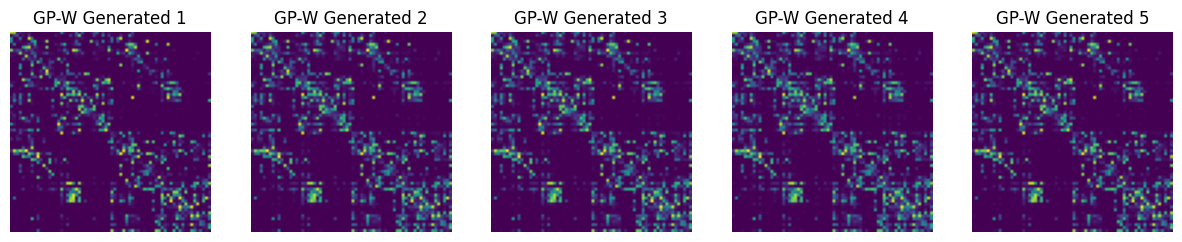

In [132]:
generator.eval()

# Generate new fake samples
with torch.no_grad():
    z_test = torch.randn(5, latent_dim)  
    new_fake = generator(z_test).cpu().numpy()
generated_connectome = new_fake[:, 0]

fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
    axes[i].imshow(generated_connectome[i], cmap="viridis")
    axes[i].set_title(f"GP-W Generated {i+1}")
    axes[i].axis("off")

plt.tight_layout
plt.show()

The obtained correlation matrices show significantly more details than with the previous, conventional, GAN approach.

# C. VAE-GAN

**i. Encoder Network (VAE)**

In [9]:
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3_mu = nn.Linear(256, latent_dim)
        self.fc3_logvar = nn.Linear(256, latent_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        mu = self.fc3_mu(x)
        logvar = self.fc3_logvar(x)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

**ii. Decoder Network** : We use our previous GAN Generator as the VAE Decoder here

**iii. Discriminator Network** : Same as the previous GAN Discriminator

**VAE-GAN Training Loop**

In [20]:
# Hyperparameters
latent_dim = 100
input_dim = 68 * 68
lr_EG = 0.0002
lr_D = 0.0002
epochs = 5000

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize models
encoder = Encoder(input_dim, latent_dim).to(device)
decoder = Generator_GAN(latent_dim).to(device)
discriminator = Discriminator_GAN().to(device)

# Optimizers
optimizer_EG = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=lr_EG, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr_D, betas=(0.5, 0.999))

# Reparameterization trick
def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

# Training function
def train_vae_gan(encoder, decoder, discriminator, dataloader, optimizer_EG, optimizer_D, epochs=100, lambda_gp=0.1):
    for epoch in range(epochs):
        encoder.train()
        decoder.train()
        discriminator.train()

        for data in dataloader:
            real_data = data[0].view(-1, 68 * 68).to(device)  # Flatten and move to device
            batch_size = real_data.size(0)

            # ===== Train Discriminator =====
            optimizer_D.zero_grad()
            z = torch.randn(batch_size, latent_dim).to(device)
            fake_data = decoder(z).detach()  # Detach to avoid generator update

            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            real_loss = nn.BCELoss()(discriminator(real_data), real_labels)
            fake_loss = nn.BCELoss()(discriminator(fake_data), fake_labels)
            loss_D = real_loss + fake_loss
            loss_D.backward()
            optimizer_D.step()

            # ===== Train Encoder-Decoder (VAE-GAN) =====
            optimizer_EG.zero_grad()

            # VAE Loss: Reconstruction + KL Divergence
            mu, logvar = encoder(real_data)
            qz = reparameterize(mu, logvar)
            recon_data = decoder(qz)

            recon_loss = recon_loss = nn.MSELoss()(recon_data.view(batch_size, -1), real_data)
            kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())  # Mean KL divergence
            vae_loss = recon_loss + kl_loss

            # GAN Loss (Generator fooling the Discriminator)
            gen_loss = nn.BCELoss()(discriminator(recon_data), real_labels)
            total_loss = vae_loss + lambda_gp * gen_loss
            total_loss.backward()
            optimizer_EG.step()
        if epoch % 500 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], VAE Loss: {vae_loss.item():.4f}, GAN Loss: {gen_loss.item():.4f}, D Loss: {loss_D.item():.4f}")

# Run Training
train_vae_gan(encoder, decoder, discriminator, train_loader, optimizer_EG, optimizer_D, epochs)

Epoch [1/5000], VAE Loss: 0.8032, GAN Loss: 0.6890, D Loss: 1.4252
Epoch [501/5000], VAE Loss: 0.0325, GAN Loss: 0.7696, D Loss: 1.3871
Epoch [1001/5000], VAE Loss: 0.0239, GAN Loss: 0.7613, D Loss: 1.3912
Epoch [1501/5000], VAE Loss: 0.0293, GAN Loss: 0.7007, D Loss: 1.3904
Epoch [2001/5000], VAE Loss: 0.0192, GAN Loss: 0.6670, D Loss: 1.3905
Epoch [2501/5000], VAE Loss: 0.0234, GAN Loss: 0.6825, D Loss: 1.3930
Epoch [3001/5000], VAE Loss: 0.0213, GAN Loss: 0.7174, D Loss: 1.3830
Epoch [3501/5000], VAE Loss: 0.0185, GAN Loss: 0.7092, D Loss: 1.3873
Epoch [4001/5000], VAE Loss: 0.0321, GAN Loss: 0.7070, D Loss: 1.3883
Epoch [4501/5000], VAE Loss: 0.0407, GAN Loss: 0.7021, D Loss: 1.4068


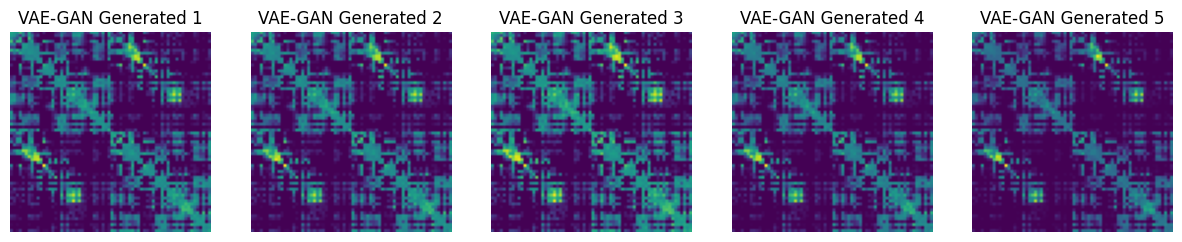

In [25]:
z = torch.randn(5, latent_dim)  # Sample random latent vectors
generated_images = decoder(z).detach().cpu().numpy()  # Generate images
generated_images = np.reshape(generated_images, (-1, 68, 68))  # Reshape

fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
    axes[i].imshow(generated_images[i], cmap="viridis")
    axes[i].set_title(f"VAE-GAN Generated {i+1}")
    axes[i].axis("off")

plt.show()

Though more blurry than with the previous WGAN-GP method, there seems to be more variation among the Generated images using VAE-GANs. This may be of higher interest in the context of medical application - i.e. obtaining less precise samples (which can later be fine-tuned) that represent a high variety of ADC connectomes among the CTRL population, rather than samples that represent with higher level of detail a lower fraction of CTRL population -such as with WGAN-GP).

# Method 2 : Using diffusion models

**i. Score Model**

In [49]:
class ScoreModel(nn.Module):
    def __init__(self):
        super(ScoreModel, self).__init__()
        self.time_embed = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 1),  # Output 1 channel for time embedding
        )
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=3, padding=1)
        )

    def forward(self, x, t):
        # Embed the time variable 't'
        t_embed = self.time_embed(t.view(-1, 1))  # Shape (batch_size, 1)
        t_embed = t_embed.view(-1, 1, 1, 1)  # Reshape to (batch_size, 1, 1, 1) for broadcasting
        
        if x.dim() == 3:
            x = x.unsqueeze(1)
        
        # Expand the time embedding to match input shape (batch_size, 1, 68, 68)
        t_embed = t_embed.expand(-1, 1, x.shape[2], x.shape[3])  # Broadcast to match spatial dimensions
        
        # Compute the score and scale by the time embedding
        return self.net(x) * t_embed  # Element-wise multiplication

**ii. Reverse SDE** : VPSDE (Variational Probabilistic Score-based Diffusion Estimation)

In [63]:
class VPSDE:
    def __init__(self, beta_min=0.1, beta_max=20, steps=1000):
        self.beta_min = beta_min
        self.beta_max = beta_max
        self.steps = steps
    
    def beta_t(self, t):
        return self.beta_min + t * (self.beta_max - self.beta_min)
    
    def perturb(self, x, t):
        t = t.view(-1, 1, 1, 1)  # Ensure correct shape for broadcasting
        beta_t = self.beta_t(t)
        noise = torch.randn_like(x)
        return x * torch.exp(-0.5 * beta_t * t) + noise * torch.sqrt(1 - torch.exp(-beta_t * t))
    
    def reverse_sde(self, score_model, x_t, device):
        dt = torch.tensor(1.0 / self.steps, device=device)  # Make dt a tensor, so torch.sqrt() works
        for i in range(self.steps):         
            # Calculate the time step (normalized to [0, 1])
            t = torch.full((x_t.shape[0], 1), i / self.steps, device=device)  # Shape [batch_size, 1]
            # Sample Gaussian noise
            z = torch.randn_like(x_t, device=device)  # Noise term (same shape as x_t)
            # Pass through the score model
            score = score_model(x_t, t)  # Shape of score will be [batch_size, 1, 68, 68]
            # Update x_t according to the reverse SDE equation
            # Fixing the dimension issue during the update step
            x_t = x_t - dt * self.beta_t(t).view(-1, 1, 1, 1) * score + torch.sqrt(dt) * z
        return x_t
    

**iii. Training loop**

In [71]:
def train_score_model(score_model, sde, train_loader, epochs=5000, lr=1e-4, device="cpu"):
    optimizer = optim.Adam(score_model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    score_model.to(device)
    score_model.train()

    for epoch in range(epochs):
        epoch_loss = 0
        for real_data in train_loader:
            real_data = real_data.to(device)
            t = torch.rand(real_data.shape[0], device=device).view(-1, 1)  # Ensure shape compatibility
            perturbed_data = sde.perturb(real_data, t)

            optimizer.zero_grad()
            estimated_score = score_model(perturbed_data, t)
            loss = criterion(estimated_score, (real_data - perturbed_data))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        if epoch % 100 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss / len(train_loader)}")

**iv. Generate connectomes**

In [72]:
def generate_connectomes(score_model, sde, num_samples=10, device='cpu'):
    score_model.to(device)
    score_model.eval()
    shape = (num_samples, 1, 68, 68)  # Ensure correct shape for Conv2D
    x_t = torch.randn(shape, device=device)
    with torch.no_grad():
        samples = sde.reverse_sde(score_model, x_t, device)
    return samples.squeeze(1).cpu()


**v. Visualize connectomes**

In [69]:
def visualize_connectomes(connectomes, num_samples=5):
    plt.figure(figsize=(15, 3))
    for i in range(min(num_samples, connectomes.shape[0])):
        plt.subplot(1, num_samples, i + 1)
        sns.heatmap(connectomes[i].squeeze(), cmap='viridis', square=True, cbar=True)  # Squeeze the 1 channel
        plt.title(f"Sample {i+1}")
        plt.axis('off')
    plt.show()


Epoch 1/5000, Loss: 1.2388643026351929
Epoch 101/5000, Loss: 0.8118183016777039
Epoch 201/5000, Loss: 0.12891146540641785
Epoch 301/5000, Loss: 0.1027054414153099
Epoch 401/5000, Loss: 0.09152916818857193
Epoch 501/5000, Loss: 0.0864747017621994
Epoch 601/5000, Loss: 0.0867348164319992
Epoch 701/5000, Loss: 0.08180992305278778
Epoch 801/5000, Loss: 0.07686305046081543
Epoch 901/5000, Loss: 0.0715305432677269
Epoch 1001/5000, Loss: 0.0737527459859848
Epoch 1101/5000, Loss: 0.07058006525039673
Epoch 1201/5000, Loss: 0.07329664379358292
Epoch 1301/5000, Loss: 0.07447510212659836
Epoch 1401/5000, Loss: 0.06924889981746674
Epoch 1501/5000, Loss: 0.0724983960390091
Epoch 1601/5000, Loss: 0.07165524363517761
Epoch 1701/5000, Loss: 0.06686753779649734
Epoch 1801/5000, Loss: 0.06842517107725143
Epoch 1901/5000, Loss: 0.06702153384685516
Epoch 2001/5000, Loss: 0.06820650398731232
Epoch 2101/5000, Loss: 0.06680775433778763
Epoch 2201/5000, Loss: 0.06884997338056564
Epoch 2301/5000, Loss: 0.066065

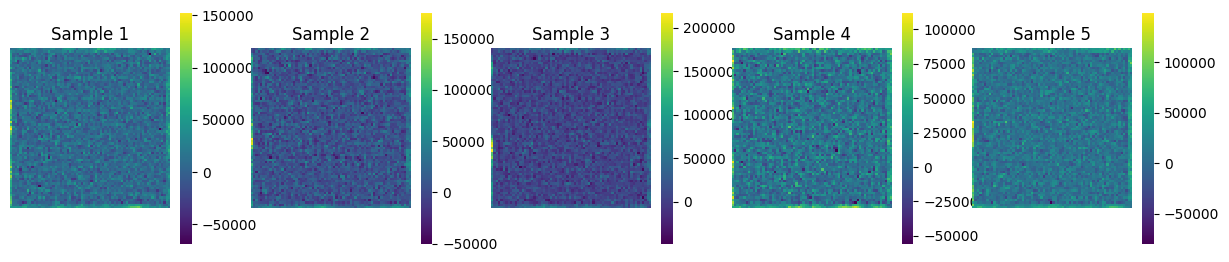

In [73]:
score_model = ScoreModel()
sde = VPSDE()
train_score_model(score_model, sde, train_loader)

# Save model
torch.save(score_model.state_dict(), "score_model.pth")

# Load model
score_model.load_state_dict(torch.load('score_model.pth'))
score_model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generate new connectomes (samples)
new_connectomes = generate_connectomes(score_model, sde, num_samples=10, device=device)

# Print the shape of generated samples
print(new_connectomes.shape)

# Visualize generated connectomes
visualize_connectomes(new_connectomes, num_samples=5)


The loss is decreasing as expected. However, visually, the results are dissatisfying. Further fine-tuning is required. Additionally, it is likely that this model is better suited for large datasets. It may be that our dataset is not sufficiently large to obtain powerful generated samples.